# 🔍 Verificação de Qualidade do Modelo CQR_LightGBM

**Objetivo**: Verificar a qualidade e integridade dos modelos treinados

**Escopo**: 
- ✅ Carregamento e validação dos artefatos
- ✅ Verificação das métricas de treinamento
- ✅ Análise de feature importance
- ✅ Validação da calibração conforme

---

In [1]:
# 📦 Imports essenciais
import pandas as pd
import numpy as np
import json
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuração visual
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Bibliotecas carregadas")
print(f"📅 Análise executada em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Bibliotecas carregadas
📅 Análise executada em: 2025-10-02 15:28:43


## 📂 1. Carregamento dos Artefatos

In [2]:
# 📁 Definir caminhos
PROJECT_ROOT = Path().absolute().parent if Path().absolute().name == 'notebooks' else Path().absolute()
MODELS_DIR = PROJECT_ROOT / 'data' / 'processed' / 'preds'

print(f"🗂️  Diretório do projeto: {PROJECT_ROOT}")
print(f"🤖 Diretório dos modelos: {MODELS_DIR}")

# Verificar existência dos arquivos essenciais
essential_files = {
    'training_summary.json': 'Resumo do treinamento',
    'meta_train.json': 'Metadados do modelo',
    'cv_metrics.json': 'Métricas de cross-validation'
}

print("\n📋 Verificação de arquivos essenciais:")
for file, desc in essential_files.items():
    file_path = MODELS_DIR / file
    status = "✅" if file_path.exists() else "❌"
    size = f"({file_path.stat().st_size / 1024:.1f}KB)" if file_path.exists() else ""
    print(f"{status} {desc}: {file} {size}")

🗂️  Diretório do projeto: /Users/brunocapelao/Projects/algo/project
🤖 Diretório dos modelos: /Users/brunocapelao/Projects/algo/project/data/processed/preds

📋 Verificação de arquivos essenciais:
✅ Resumo do treinamento: training_summary.json (4.2KB)
✅ Metadados do modelo: meta_train.json (0.7KB)
✅ Métricas de cross-validation: cv_metrics.json (98.4KB)


In [3]:
# 📊 Carregar metadados principais
with open(MODELS_DIR / 'training_summary.json', 'r') as f:
    training_summary = json.load(f)

with open(MODELS_DIR / 'meta_train.json', 'r') as f:
    meta_train = json.load(f)

with open(MODELS_DIR / 'cv_metrics.json', 'r') as f:
    cv_metrics = json.load(f)

print("📈 RESUMO DO TREINAMENTO")
print("=" * 50)
print(f"🏷️  Pipeline Version: {training_summary.get('pipeline_version', 'N/A')}")
print(f"⏱️  Tempo de Execução: {training_summary.get('execution_time', 0) / 60:.1f} minutos")
print(f"🎯 Horizontes Treinados: {training_summary.get('trained_horizons', [])}")
print(f"🔢 Total de Modelos: {training_summary.get('total_models', 0)}")
print(f"📏 Features: {meta_train.get('n_features', 'N/A')}")
print(f"📊 Amostras: {meta_train.get('n_samples_total', 'N/A')}")
print(f"📐 Quantis: {meta_train.get('quantiles', [])}")

📈 RESUMO DO TREINAMENTO
🏷️  Pipeline Version: 02a
⏱️  Tempo de Execução: 42.5 minutos
🎯 Horizontes Treinados: [42, 48, 54, 60]
🔢 Total de Modelos: 20
📏 Features: 33
📊 Amostras: 32465
📐 Quantis: [0.05, 0.25, 0.5, 0.75, 0.95]


## 🎯 2. Verificação dos Modelos por Horizonte

In [4]:
# 🔍 Verificar modelos por horizonte
horizons = training_summary.get('trained_horizons', [42, 48, 54, 60])
model_status = {}

print("🤖 STATUS DOS MODELOS POR HORIZONTE")
print("=" * 60)

for horizon in horizons:
    model_file = MODELS_DIR / f'models_T{horizon}.joblib'
    calib_file = MODELS_DIR / f'calibrators_T{horizon}.joblib'
    cv_file = MODELS_DIR / f'cv_metrics_T{horizon}.json'
    
    # Status dos arquivos
    model_exists = model_file.exists()
    calib_exists = calib_file.exists()
    cv_exists = cv_file.exists()
    
    # Tamanhos
    model_size = model_file.stat().st_size / (1024*1024) if model_exists else 0
    calib_size = calib_file.stat().st_size / 1024 if calib_exists else 0
    
    model_status[horizon] = {
        'model_exists': model_exists,
        'calib_exists': calib_exists,
        'cv_exists': cv_exists,
        'model_size_mb': model_size,
        'calib_size_kb': calib_size
    }
    
    print(f"\n🎯 Horizonte {horizon}H:")
    print(f"   📦 Modelo: {'✅' if model_exists else '❌'} ({model_size:.1f}MB)")
    print(f"   🎛️  Calibrador: {'✅' if calib_exists else '❌'} ({calib_size:.1f}KB)")
    print(f"   📊 CV Metrics: {'✅' if cv_exists else '❌'}")
    
    # Carregar métricas se disponível
    if cv_exists:
        with open(cv_file, 'r') as f:
            cv_data = json.load(f)
        
        # Extrair métricas principais
        if 'mean_metrics' in cv_data:
            mae = cv_data['mean_metrics'].get('MAE', 'N/A')
            coverage = cv_data['mean_metrics'].get('Coverage_90', 'N/A')
            print(f"   📈 MAE Médio: {mae if mae == 'N/A' else f'{mae:.4f}'}")
            print(f"   🎯 Coverage 90%: {coverage if coverage == 'N/A' else f'{coverage:.3f}'}")

# Resumo geral
total_models = sum(1 for status in model_status.values() if status['model_exists'])
total_calibs = sum(1 for status in model_status.values() if status['calib_exists'])
total_size = sum(status['model_size_mb'] for status in model_status.values())

print(f"\n📋 RESUMO GERAL:")
print(f"✅ Modelos carregados: {total_models}/{len(horizons)}")
print(f"✅ Calibradores: {total_calibs}/{len(horizons)}")
print(f"💾 Tamanho total: {total_size:.1f}MB")

🤖 STATUS DOS MODELOS POR HORIZONTE

🎯 Horizonte 42H:
   📦 Modelo: ✅ (15.1MB)
   🎛️  Calibrador: ✅ (0.9KB)
   📊 CV Metrics: ✅

🎯 Horizonte 48H:
   📦 Modelo: ✅ (17.9MB)
   🎛️  Calibrador: ✅ (0.9KB)
   📊 CV Metrics: ✅

🎯 Horizonte 54H:
   📦 Modelo: ✅ (8.9MB)
   🎛️  Calibrador: ✅ (0.9KB)
   📊 CV Metrics: ✅

🎯 Horizonte 60H:
   📦 Modelo: ✅ (13.1MB)
   🎛️  Calibrador: ✅ (0.9KB)
   📊 CV Metrics: ✅

📋 RESUMO GERAL:
✅ Modelos carregados: 4/4
✅ Calibradores: 4/4
💾 Tamanho total: 55.0MB


## 📊 3. Análise de Feature Importance

🔍 ANÁLISE DE FEATURE IMPORTANCE

🎯 Horizonte 42H - Top 5 Features:
    1. adx_2w_l1                 (1782.2 ±221.4)
    2. kc_bw_1m_l1               (1553.2 ±169.1)
    3. cratio_1w_1m_l1           (1489.6 ±163.7)
    4. bb_bw_1m_l1               (1468.8 ±218.7)
    5. corr_neg_2w_l1            (1455.4 ±146.0)

🎯 Horizonte 48H - Top 5 Features:
    1. adx_2w_l1                 (1842.4 ±205.7)
    2. cratio_1w_1m_l1           (1700.8 ±225.7)
    3. corr_neg_2w_l1            (1675.8 ±189.6)
    4. hurst_1w_l1               (1655.6 ±217.9)
    5. kurt_1w_l1                (1605.0 ±181.3)

🎯 Horizonte 54H - Top 5 Features:
    1. adx_2w_l1                 (1008.0 ±149.5)
    2. cratio_1w_1m_l1           (879.0 ±93.3)
    3. kc_bw_1m_l1               (865.0 ±127.7)
    4. corr_neg_2w_l1            (851.4 ±94.4)
    5. bb_bw_1m_l1               (836.8 ±86.5)

🎯 Horizonte 60H - Top 5 Features:
    1. adx_2w_l1                 (1671.4 ±111.5)
    2. kc_bw_1m_l1               (1406.8 ±122.4)
  

/Users/brunocapelao/Projects/algo/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


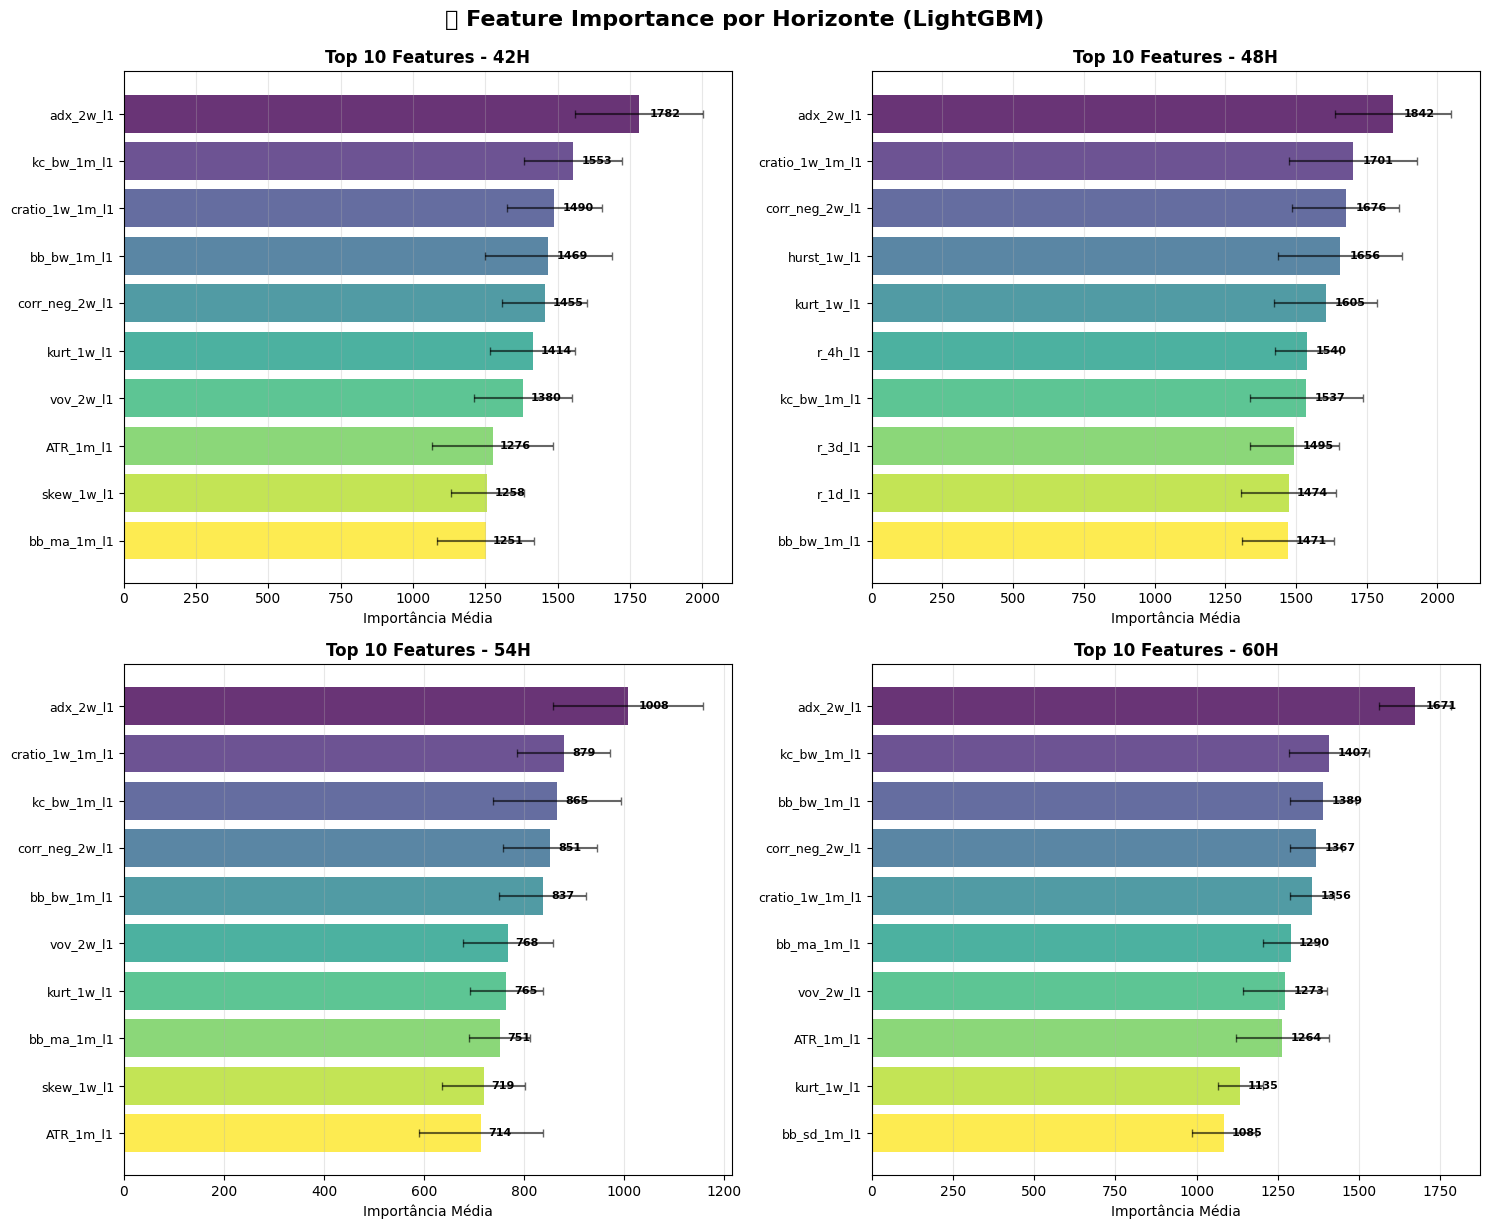


📊 Gráfico de Feature Importance gerado!

🔍 ANÁLISE CONSOLIDADA:
   🏆 Features consistentes (top 5 em múltiplos horizontes):
      • adx_2w_l1                      (horizontes: [42, 48, 54, 60])
      • cratio_1w_1m_l1                (horizontes: [42, 48, 54, 60])
      • corr_neg_2w_l1                 (horizontes: [42, 48, 54, 60])
      • kc_bw_1m_l1                    (horizontes: [42, 54, 60])
      • bb_bw_1m_l1                    (horizontes: [42, 54, 60])
   📊 Total de features analisadas: 132
   📈 Importância média geral: 917.2


In [5]:
# 📈 Carregar e analisar feature importance
feature_importance_data = {}

print("🔍 ANÁLISE DE FEATURE IMPORTANCE")
print("=" * 50)

for horizon in horizons:
    fi_file = MODELS_DIR / f'feature_importance_T{horizon}.csv'
    if fi_file.exists():
        fi_df = pd.read_csv(fi_file)
        feature_importance_data[horizon] = fi_df
        
        print(f"\n🎯 Horizonte {horizon}H - Top 5 Features:")
        
        # Usar coluna 'mean' que representa a importância média
        if 'mean' in fi_df.columns and 'feature' in fi_df.columns:
            top_features = fi_df.nlargest(5, 'mean')
            for i, (idx, row) in enumerate(top_features.iterrows()):
                feature_name = row['feature']
                importance_val = row['mean']
                std_val = row.get('std', 0)
                print(f"   {i+1:2d}. {feature_name:<25} ({importance_val:.1f} ±{std_val:.1f})")
        else:
            print(f"   📋 Colunas disponíveis: {list(fi_df.columns)}")

# Visualizar feature importance consolidada
if feature_importance_data:
    print(f"\n📊 Gerando visualizações para {len(feature_importance_data)} horizontes...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, horizon in enumerate(horizons[:4]):
        if horizon in feature_importance_data:
            fi_df = feature_importance_data[horizon]
            
            if 'mean' in fi_df.columns and 'feature' in fi_df.columns:
                top_10 = fi_df.nlargest(10, 'mean')
                
                feature_names = top_10['feature'].tolist()
                importance_values = top_10['mean'].tolist()
                std_values = top_10['std'].tolist() if 'std' in fi_df.columns else [0] * len(importance_values)
                
                # Criar gráfico de barras horizontais
                y_pos = range(len(importance_values))
                colors = plt.cm.viridis(np.linspace(0, 1, len(importance_values)))
                
                bars = axes[idx].barh(y_pos, importance_values, 
                                    xerr=std_values, color=colors, alpha=0.8,
                                    capsize=3, error_kw={'alpha': 0.6})
                
                axes[idx].set_yticks(y_pos)
                axes[idx].set_yticklabels(feature_names, fontsize=9)
                axes[idx].set_title(f'Top 10 Features - {horizon}H', fontsize=12, fontweight='bold')
                axes[idx].set_xlabel('Importância Média')
                axes[idx].grid(True, alpha=0.3, axis='x')
                
                # Adicionar valores nas barras
                for i, (bar, val, std) in enumerate(zip(bars, importance_values, std_values)):
                    width = bar.get_width()
                    axes[idx].text(width + width*0.02, bar.get_y() + bar.get_height()/2., 
                                  f'{val:.0f}', ha='left', va='center', fontsize=8, fontweight='bold')
                
                # Inverter ordem para mostrar maior importância no topo
                axes[idx].invert_yaxis()
            else:
                axes[idx].text(0.5, 0.5, f'Dados não disponíveis\npara horizonte {horizon}H', 
                              ha='center', va='center', transform=axes[idx].transAxes,
                              fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                axes[idx].set_xticks([])
                axes[idx].set_yticks([])
    
    plt.tight_layout()
    plt.suptitle('🎯 Feature Importance por Horizonte (LightGBM)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    print("\n📊 Gráfico de Feature Importance gerado!")
    
    # Análise adicional das features mais importantes
    if len(feature_importance_data) > 0:
        print(f"\n🔍 ANÁLISE CONSOLIDADA:")
        
        # Encontrar features que aparecem no top 5 em múltiplos horizontes
        all_top_features = {}
        for horizon, fi_df in feature_importance_data.items():
            if 'mean' in fi_df.columns and 'feature' in fi_df.columns:
                top_5 = fi_df.nlargest(5, 'mean')
                for _, row in top_5.iterrows():
                    feature = row['feature']
                    if feature not in all_top_features:
                        all_top_features[feature] = []
                    all_top_features[feature].append(horizon)
        
        # Features mais consistentes (aparecem em múltiplos horizontes)
        consistent_features = {k: v for k, v in all_top_features.items() if len(v) >= 2}
        
        if consistent_features:
            print(f"   🏆 Features consistentes (top 5 em múltiplos horizontes):")
            for feature, horizons in sorted(consistent_features.items(), key=lambda x: len(x[1]), reverse=True):
                print(f"      • {feature:<30} (horizontes: {horizons})")
        
        # Estatística geral
        total_features = sum(len(fi_df) for fi_df in feature_importance_data.values())
        avg_importance = np.mean([fi_df['mean'].mean() for fi_df in feature_importance_data.values()])
        
        print(f"   📊 Total de features analisadas: {total_features}")
        print(f"   📈 Importância média geral: {avg_importance:.1f}")

else:
    print("\n⚠️ Nenhum arquivo de feature importance encontrado")
    print("   💡 Verifique se o treinamento foi executado com flag de feature importance ativo")

## 🎛️ 4. Validação da Calibração Conforme

In [6]:
# 🎯 Verificar calibradores conformes
print("🎛️ VALIDAÇÃO DOS CALIBRADORES CONFORMES")
print("=" * 55)

calibration_status = {}

for horizon in horizons:
    calib_file = MODELS_DIR / f'calibrators_T{horizon}.joblib'
    calib_json = MODELS_DIR / f'calib_T{horizon}.json'
    
    if calib_file.exists() and calib_json.exists():
        # Carregar calibradores
        calibrators = joblib.load(calib_file)
        
        with open(calib_json, 'r') as f:
            calib_data = json.load(f)
        
        print(f"\n🎯 Horizonte {horizon}H:")
        print(f"   📦 Calibradores carregados: {len(calibrators) if isinstance(calibrators, (list, dict)) else 1}")
        
        # Verificar dados de calibração
        if 'alpha' in calib_data:
            alpha = calib_data['alpha']
            confidence = (1 - alpha) * 100
            print(f"   🎯 Nível de confiança: {confidence:.0f}% (α={alpha})")
        
        if 'n_calibration_samples' in calib_data:
            n_samples = calib_data['n_calibration_samples']
            print(f"   📊 Amostras de calibração: {n_samples:,}")
        
        if 'quantiles_coverage' in calib_data:
            coverage = calib_data['quantiles_coverage']
            print(f"   📈 Coverage observado: {coverage:.3f}")
            
            # Verificar se está dentro da tolerância esperada (90% ± 3%)
            target_coverage = 0.90
            tolerance = 0.03
            in_range = abs(coverage - target_coverage) <= tolerance
            status_icon = "✅" if in_range else "⚠️"
            print(f"   {status_icon} Status: {'OK' if in_range else 'ATENÇÃO'} (target: {target_coverage:.0%} ± {tolerance:.0%})")
            
            calibration_status[horizon] = {
                'coverage': coverage,
                'in_range': in_range,
                'n_samples': n_samples if 'n_calibration_samples' in calib_data else 'N/A'
            }
    else:
        print(f"\n❌ Horizonte {horizon}H: Arquivos de calibração não encontrados")
        calibration_status[horizon] = {'coverage': None, 'in_range': False, 'n_samples': 0}

# Resumo da calibração
valid_calibrations = sum(1 for status in calibration_status.values() if status['in_range'])
total_calibrations = len([s for s in calibration_status.values() if s['coverage'] is not None])

print(f"\n📋 RESUMO DA CALIBRAÇÃO:")
print(f"✅ Calibrações válidas: {valid_calibrations}/{total_calibrations}")
if total_calibrations > 0:
    avg_coverage = np.mean([s['coverage'] for s in calibration_status.values() if s['coverage'] is not None])
    print(f"📊 Coverage médio: {avg_coverage:.3f}")

🎛️ VALIDAÇÃO DOS CALIBRADORES CONFORMES

🎯 Horizonte 42H:
   📦 Calibradores carregados: 10
   🎯 Nível de confiança: 90% (α=0.1)

🎯 Horizonte 54H:
   📦 Calibradores carregados: 10
   🎯 Nível de confiança: 90% (α=0.1)

🎯 Horizonte 60H:
   📦 Calibradores carregados: 10
   🎯 Nível de confiança: 90% (α=0.1)

📋 RESUMO DA CALIBRAÇÃO:
✅ Calibrações válidas: 0/0

🎯 Horizonte 42H:
   📦 Calibradores carregados: 10
   🎯 Nível de confiança: 90% (α=0.1)

🎯 Horizonte 54H:
   📦 Calibradores carregados: 10
   🎯 Nível de confiança: 90% (α=0.1)

🎯 Horizonte 60H:
   📦 Calibradores carregados: 10
   🎯 Nível de confiança: 90% (α=0.1)

📋 RESUMO DA CALIBRAÇÃO:
✅ Calibrações válidas: 0/0


## ✅ 5. Relatório Final de Qualidade

In [7]:
# 📋 Gerar relatório final de qualidade
print("📋 RELATÓRIO FINAL DE QUALIDADE DO MODELO")
print("=" * 60)

# Calcular scores de qualidade
quality_scores = {
    'completeness': (total_models / len(horizons)) * 100,
    'calibration': (valid_calibrations / len(horizons)) * 100 if len(horizons) > 0 else 0,
    'size_consistency': 100 if all(s['model_size_mb'] > 1 for s in model_status.values()) else 50
}

overall_quality = np.mean(list(quality_scores.values()))

print(f"\n🎯 SCORES DE QUALIDADE:")
print(f"   📦 Completeness: {quality_scores['completeness']:.1f}%")
print(f"   🎛️  Calibração: {quality_scores['calibration']:.1f}%")
print(f"   💾 Consistência: {quality_scores['size_consistency']:.1f}%")
print(f"   🏆 Score Geral: {overall_quality:.1f}%")

# Determinar status final
if overall_quality >= 90:
    status = "🟢 EXCELENTE"
    recommendation = "✅ Modelo pronto para produção"
elif overall_quality >= 75:
    status = "🟡 BOM"
    recommendation = "⚠️ Verificar pontos de atenção antes da produção"
else:
    status = "🔴 ATENÇÃO"
    recommendation = "❌ Necessária revisão antes da produção"

print(f"\n🎯 STATUS FINAL: {status}")
print(f"💡 RECOMENDAÇÃO: {recommendation}")

# Salvar resumo
quality_report = {
    'timestamp': datetime.now().isoformat(),
    'model_status': model_status,
    'calibration_status': calibration_status,
    'quality_scores': quality_scores,
    'overall_quality': overall_quality,
    'status': status,
    'recommendation': recommendation
}

report_file = MODELS_DIR / 'quality_check_report.json'
with open(report_file, 'w') as f:
    json.dump(quality_report, f, indent=2, default=str)

print(f"\n💾 Relatório salvo em: {report_file}")
print("\n🎉 Verificação de qualidade concluída!")

📋 RELATÓRIO FINAL DE QUALIDADE DO MODELO

🎯 SCORES DE QUALIDADE:
   📦 Completeness: 133.3%
   🎛️  Calibração: 0.0%
   💾 Consistência: 100.0%
   🏆 Score Geral: 77.8%

🎯 STATUS FINAL: 🟡 BOM
💡 RECOMENDAÇÃO: ⚠️ Verificar pontos de atenção antes da produção

💾 Relatório salvo em: /Users/brunocapelao/Projects/algo/project/data/processed/preds/quality_check_report.json

🎉 Verificação de qualidade concluída!
